In [1]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.util import ngrams
from time import time
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score

In [2]:
#read columns = 5(gender),7(profile_yn),10(description),19(text) from the given dataset
data = pd.read_csv("gender-classifier.csv", encoding = "latin1", usecols = [5,7,10,19])

In [3]:
#drop the records with profile_yn = no
drop_items_idx = data[data['profile_yn'] == 'no'].index
data.drop(data.index[drop_items_idx], inplace = True)

In [4]:
#drop the records with nan values in text and description attributes
data = data.dropna(subset=['text','description'])

In [5]:
#encode the gender attributes using LabelEncoder
#brand = 0, female = 1, male = 2, unknown = 3
gender_encoder = LabelEncoder()
data['Gender'] = gender_encoder.fit_transform(data['gender'])

In [6]:
#replace the records with gender = "unkwown" to the most_frequent value of the column
from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values = 3, strategy = "most_frequent", axis = 0)
data['Gender'] = imputer.fit_transform(data[['Gender']]).ravel()

In [7]:
#open the stopwords file imported from the nltk library
with open("stopwords.txt","r") as file:
    stopwords = file.read().split("\n")
        
# clean the data in "text" and "description" attribute
def cleaning(s):
    s = str(s)
    s = s.lower()
    s = s.replace("'s",' is')
    s = s.replace("'re",' are')
    s = s.replace("'ve",' have')
    sentence = []
    for word in s.split(' '):
        word = re.sub(r'[ _]', '', word)
        word = re.sub('[^\w\s]', '', word)
        word = re.sub('\s\W','',word)  
        word = re.sub('\W\s','',word) 
        word = re.sub(r'http\S+','', word)

        if (word not in stopwords):
            word = ''.join(char for char in word if ord(char)<128)            
            sentence.append(word)
    return " ".join(sentence)
        

data['text'] = [cleaning(s) for s in data['text']]
data['description'] = [cleaning(s) for s in data['description']]

In [8]:
#lemmatize the tokens from "text" and "description" attribute to their dictionary words
lemma = nltk.WordNetLemmatizer()
def lemmatization(column_name):
    corpus = []
    for entry in data[column_name]:
        entry = str(entry)
        entry = nltk.word_tokenize(entry)
        entry = [lemma.lemmatize(word) for word in entry]
        for word in entry:
            if(word not in stopwords):
                word = re.sub('[^\w\s]', '', word)        
        entry = " ".join(entry)
        corpus.append(entry)
    return corpus

descriptionList = lemmatization('description')        
tweetList = lemmatization("text")


In [9]:
#tf-idf vectorizer with n-grams = (1,4)
tweet_vectorizer = TfidfVectorizer(max_features = 15000, ngram_range = (1,4))    
description_vectorizer = TfidfVectorizer(max_features = 15000, ngram_range = (1,4))    

text_corpus = tweet_vectorizer.fit_transform(tweetList).toarray()
description_corpus = description_vectorizer.fit_transform(descriptionList).toarray()

In [10]:
#concatenate the text and description corpus
finalDf = np.concatenate((text_corpus, description_corpus), axis = 1)

In [11]:
x = finalDf[:,:] #combination of text and description corpus
y = data.iloc[:,-1].values # gender attribute

In [12]:
#feature selection
selector = SelectKBest(chi2, k = 8000).fit(x,y)
x = selector.transform(x)


In [13]:
#train-test split to generate test set and training set
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2, random_state = 0)

In [14]:
#Multinomial Naive Bayes Classifier
from sklearn.naive_bayes import MultinomialNB

NaiveBayes_Classifier = MultinomialNB()
NaiveBayes_Classifier.fit(x_train,y_train)
t = time()
y_predGNB = NaiveBayes_Classifier.predict(x_test)

cm = confusion_matrix(y_test, y_predGNB)
print("time taken: ", round(time() - t, 3), "s")
print(classification_report(y_test, y_predGNB, target_names=['brand', 'female', 'male']))
print("accuracy: ",NaiveBayes_Classifier.score(x_test,y_test))

time taken:  0.1 s
             precision    recall  f1-score   support

      brand       0.86      0.55      0.67       860
     female       0.63      0.84      0.72      1312
       male       0.64      0.57      0.60      1079

avg / total       0.69      0.67      0.67      3251

accuracy:  0.671485696709


In [15]:
#Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
RandomForest_classifier = RandomForestClassifier(n_estimators = 80, random_state = 0, max_depth=100)
RandomForest_classifier.fit(x_train,y_train)
t = time()
y_predRFC = RandomForest_classifier.predict(x_test)

cm = confusion_matrix(y_test, y_predRFC)
print("time taken: ", round(time() - t, 3), "s")
print(classification_report(y_test, y_predRFC, target_names=['brand', 'female', 'male']))
print("accuracy: ",RandomForest_classifier.score(x_test,y_test))


time taken:  0.863 s
             precision    recall  f1-score   support

      brand       0.77      0.50      0.60       860
     female       0.52      0.86      0.65      1312
       male       0.62      0.32      0.42      1079

avg / total       0.62      0.58      0.56      3251

accuracy:  0.581667179329


In [16]:
#Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression
LogisticRegression_classifier = LogisticRegression(multi_class='ovr', random_state = 0)
LogisticRegression_classifier.fit(x_train,y_train)
t = time()
y_predLR = LogisticRegression_classifier.predict(x_test)

cm = confusion_matrix(y_test, y_predLR)
print("time taken: ", round(time() - t, 3), "s")
print(classification_report(y_test, y_predLR, target_names=['brand', 'female', 'male']))
print("accuracy: ",LogisticRegression_classifier.score(x_test,y_test))

time taken:  0.083 s
             precision    recall  f1-score   support

      brand       0.80      0.64      0.71       860
     female       0.63      0.78      0.69      1312
       male       0.63      0.55      0.58      1079

avg / total       0.67      0.66      0.66      3251

accuracy:  0.664103352815


In [17]:
#Linear SVM Classifier
from sklearn.svm import LinearSVC
SVM_classifier = LinearSVC()
SVM_classifier.fit(x_train, y_train)
t = time()
y_predSVC = SVM_classifier.predict(x_test)

cm = confusion_matrix(y_test, y_predSVC)
print("time taken: ", round(time() - t, 3), "s")
print(classification_report(y_test, y_predSVC, target_names=['brand', 'female', 'male']))
print("accuracy: ", SVM_classifier.score(x_test,y_test))

time taken:  0.083 s
             precision    recall  f1-score   support

      brand       0.78      0.67      0.72       860
     female       0.68      0.77      0.72      1312
       male       0.65      0.62      0.64      1079

avg / total       0.70      0.70      0.69      3251

accuracy:  0.695170716703


In [ ]:
#KNN Classifier
from sklearn.neighbors import KNeighborsClassifier
KNN_classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
KNN_classifier.fit(x_train, y_train)
t = time()
y_predKNN = KNN_classifier.predict(x_test)

cm = confusion_matrix(y_test, y_predKNN)
print("time taken: ", round(time() - t, 3), "s")
print(classification_report(y_test, y_predSVC, target_names=['brand', 'female', 'male']))
print("accuracy: ", KNN_classifier.score(x_test,y_test))

In [18]:
#Ensemble Classifier (Voting)
from sklearn.ensemble import VotingClassifier
ensemble_classifier = VotingClassifier(estimators=[('mnb', NaiveBayes_Classifier), ('SVM', SVM_classifier )], voting='hard')
ensemble_classifier.fit(x_train, y_train)
t = time()
y_predEnsem = ensemble_classifier.predict(x_test)

cm = confusion_matrix(y_test, y_predEnsem)
print("time taken: ", round(time() - t, 3), "s")
print(classification_report(y_test, y_predEnsem, target_names=['brand', 'female', 'male']))
print("accuracy: ", ensemble_classifier.score(x_test,y_test))

time taken:  0.204 s
             precision    recall  f1-score   support

      brand       0.77      0.69      0.73       860
     female       0.64      0.83      0.72      1312
       male       0.70      0.50      0.59      1079

avg / total       0.69      0.69      0.68      3251

accuracy:  0.685635189173


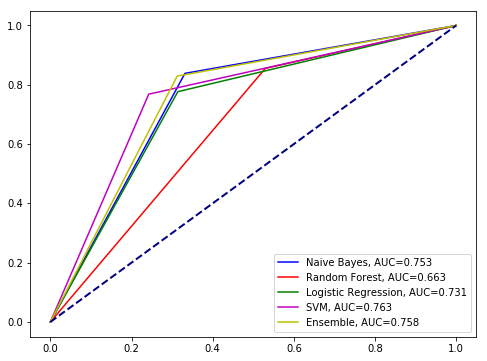

In [19]:
#plotting roc curve
y_test = [ i if (i==1) else 0 for i in y_test  ]

plt.figure()
plt.subplots(figsize=(8,6))

y_predGNB = [ i if (i==1) else 0 for i in y_predGNB  ]
fpr, tpr, _ = roc_curve(y_test, y_predGNB, pos_label=1)
plt.plot(fpr, tpr, 'b', label="Naive Bayes, AUC=" + str(round(roc_auc_score(y_test, y_predGNB), 3)))

y_predRFC = [ i if (i==1) else 0 for i in y_predRFC ]
fpr, tpr, _ = roc_curve(y_test, y_predRFC)
plt.plot(fpr, tpr, 'r', label="Random Forest, AUC=" + str(round(roc_auc_score(y_test, y_predRFC), 3)))

y_predLR = [ i if (i==1) else 0 for i in y_predLR  ]
fpr, tpr, _ = roc_curve(y_test, y_predLR)
plt.plot(fpr, tpr, 'g', label="Logistic Regression, AUC=" + str(round(roc_auc_score(y_test, y_predLR), 3)))

y_predSVC = [ i if (i==1) else 0 for i in y_predSVC  ]
fpr, tpr, _ = roc_curve(y_test, y_predSVC)
plt.plot(fpr, tpr, 'm', label="SVM, AUC=" + str(round(roc_auc_score(y_test, y_predSVC), 3)))

y_predEnsem = [ i if (i==1) else 0 for i in y_predEnsem  ]
fpr, tpr, _ = roc_curve(y_test, y_predEnsem)
plt.plot(fpr, tpr, 'y', label="Ensemble, AUC=" + str(round(roc_auc_score(y_test, y_predEnsem), 3)))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend()
plt.show()